### IMPORTS
---

In [ ]:
## Install these packages if needeed
%pip install pandas
%pip install ydata-profiling
%pip install -U scikit-learn
%conda install -c conda-forge imbalanced-learn

In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_csv, DataFrame
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from src.utils import get_model, train_model, test_model, save_model

import warnings 
warnings. filterwarnings('ignore')

### DATA
---

In [2]:
data = read_csv(filepath_or_buffer=".data/term-deposit-marketing-2020.csv")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [4]:
data.shape  # Note : not a small dataset

(40000, 14)

In [5]:
data.info()  # Good <> No missing-values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
data.describe(include="all")  # only numerical attributes considered
# 50 % of customers have less than 39 years old, have <= 407$ balance

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
count,40000.000000,40000,40000,40000,40000,40000.000000,40000,40000,40000,40000.000000,40000,40000.000000,40000.000000,40000
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,11,NaN,NaN,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,no
freq,NaN,9383,24386,20993,39191,NaN,24031,33070,24914,NaN,13532,NaN,NaN,37104
mean,40.544600,NaN,NaN,NaN,NaN,1274.277550,NaN,NaN,NaN,16.017225,NaN,254.824300,2.882175,NaN
std,9.641776,NaN,NaN,NaN,NaN,2903.769716,NaN,NaN,NaN,8.278127,NaN,259.366498,3.239051,NaN
min,19.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,54.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,NaN
50%,39.000000,NaN,NaN,NaN,NaN,407.000000,NaN,NaN,NaN,17.000000,NaN,175.000000,2.000000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1319.000000,NaN,NaN,NaN,21.000000,NaN,313.000000,3.000000,NaN


In [7]:
# Notes <> Attributes
# - marital : categorical, binary
# - education : categorical, ordinal
# - default : categorical, binary
# - housing : categorical, binary
# - loan : categorical, binary
# - month : categorical, ordinal
# - contact - categorical, multiple values possibles

In [54]:
data.value_counts(
    subset=["y"], normalize=True, dropna=True
).to_frame()  # Note : A huge data imbalance

,0
y,
no,0.9276
yes,0.0724


### EDA
----

In [9]:
profile = ProfileReport(
    df=data
)  # Note : duration is the feature with the highest correlation with y

In [10]:
profile.to_file(output_file=".data/eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### MODELLING
---

In [3]:
from typing import Optional, List, Literal, Callable
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from pandas import DataFrame
from tqdm import tqdm
from contextlib import suppress

In [4]:
def create_data_prepocessing_pipeline(
    numeric: Optional[List[str]] = None,
    nominal: Optional[List[str]] = None,
    ordinal: Optional[List[str]] = None,
) -> ColumnTransformer:
    """
    Create a data preprocessing pipeline using scikit-learn's ColumnTransformer.

    Args:
        numeric (Optional[List[str]]): List of numeric column names. Defaults to None.
        nominal (Optional[List[str]]): List of nominal column names. Defaults to None.
        ordinal (Optional[List[str]]): List of ordinal column names. Defaults to None.

    Returns:
        ColumnTransformer: Preprocessing pipeline.

    """
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder())])
    ordinal_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric),
            ("cat", categorical_transformer, nominal),
            ("ord", ordinal_transformer, ordinal),
        ]
    )


def run_experiment(
    df: DataFrame,
    preprocessor: ColumnTransformer,
    eval_metrics: List[str],
    target: str = "y",
    models: Optional[List[str]] = None,
    task: Optional[Literal["classifier", "regressor"]] = None,
    pipeline_func: Optional[Callable] = make_pipeline,
    additional_steps: Optional[List[Callable]] = None,
    **kwargs,
) -> DataFrame:
    """
    Run an experiment to evaluate multiple models on a given dataset.

    Args:
        df (DataFrame): Input dataset.
        preprocessor (ColumnTransformer): Preprocessing pipeline.
        eval_metrics (List[str]): List of evaluation metrics to calculate.
        target (str, optional): Target column name. Defaults to "y".
        models (Optional[List[str]], optional): List of model names to evaluate. Defaults to None.
        task (Optional[Literal["classifier", "regressor"]], optional): Task type. Defaults to None.
        additional_steps (Optional[List[Callable]]): List of additional processing steps. Defaults to None.
        **kwargs: Additional keyword arguments for model initialization.

    Returns:
        DataFrame: Experiment results with model names and evaluation metrics.

    """
    X, y = df.drop(target, axis=1), df[target]

    lb = LabelBinarizer()
    y = lb.fit_transform(y)
    print(lb.classes_)  # the positive class willbe 'yes' and 'no' the negative one

    models = (
        get_model(task=task)
        if models is None
        else list(
            map(lambda model: get_model(model_name=model, task=task, **kwargs)[-1], models)
        )
    )
    # print(models)
    experiment = []
    for model in tqdm(models[:]):
        with suppress(ValueError):
            clf = pipeline_func(preprocessor, model)
           
            if additional_steps:
                for step in additional_steps:
                    clf.steps.insert(-1, step)
            
            scores = cross_validate(
                estimator=clf,
                X=X,
                y=y,
                cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                scoring=eval_metrics,
            )
            avg_perf = [
                scores[f"test_{metric_name}"].mean() for metric_name in eval_metrics
            ]
            experiment.append([model.__class__.__name__, *avg_perf])

    return DataFrame(data=experiment, columns=["Model", *eval_metrics])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

### Preprocessing

In [5]:
columns = {
    "numeric": ["age", "balance", "day", "duration", "campaign"],
    "nominal": ["job", "marital", "default", "housing", "loan", "contact"],
    "ordinal": ["education", "month"],
}
preprocessor = create_data_prepocessing_pipeline(**columns)
data_trans = preprocessor.fit_transform(
    data
)  # Just to take a look - the preprocessing part before we embedded it in the next pipeline
print(data_trans.shape, preprocessor.get_feature_names_out())

(40000, 31) ['num__age' 'num__balance' 'num__day' 'num__duration' 'num__campaign'
 'cat__job_admin' 'cat__job_blue-collar' 'cat__job_entrepreneur'
 'cat__job_housemaid' 'cat__job_management' 'cat__job_retired'
 'cat__job_self-employed' 'cat__job_services' 'cat__job_student'
 'cat__job_technician' 'cat__job_unemployed' 'cat__job_unknown'
 'cat__marital_divorced' 'cat__marital_married' 'cat__marital_single'
 'cat__default_no' 'cat__default_yes' 'cat__housing_no' 'cat__housing_yes'
 'cat__loan_no' 'cat__loan_yes' 'cat__contact_cellular'
 'cat__contact_telephone' 'cat__contact_unknown' 'ord__education'
 'ord__month']


### Model Selection

In [6]:
result = run_experiment(
    data,
    preprocessor,
    task="classifier",
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
)
result.style.apply(highlight_max)

['no' 'yes']


100%|██████████| 31/31 [4:44:59<00:00, 551.61s/it]    


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,AdaBoostClassifier,0.930825,0.646589,0.396197,0.537964,0.314226
1,BernoulliNB,0.919175,0.549577,0.173831,0.335361,0.117401
2,DecisionTreeClassifier,0.915000,0.695047,0.427050,0.417116,0.437851
3,DummyClassifier,0.927600,0.500000,0.000000,0.000000,0.000000
4,ExtraTreeClassifier,0.904875,0.635951,0.328283,0.335592,0.321492
5,ExtraTreesClassifier,0.932725,0.589670,0.288213,0.615064,0.188530
6,GaussianNB,0.891775,0.691121,0.379238,0.324394,0.456493
7,GaussianProcessClassifier,nan,nan,nan,nan,nan
8,HistGradientBoostingClassifier,0.938075,0.692681,0.486779,0.608594,0.405738
9,KNeighborsClassifier,0.932075,0.636921,0.382962,0.558955,0.291791


In [55]:
# NOTE:
# -Dummy classifier (baseline) has  almost 93% accuracy (but only 50% balanced accuracy). As the dataset is heavily imbalanced, we cannot rely
# on accuracy (the classic one) alone to select our best model. We can use :
#   - the balanced accuracy to help us choose the best model (more than 50% of balanced accuracy).
#   - and Precision and recall will help us, depending on which class (positive or negative is more important for the current task)
# -If we prioritize capturing all positive instances, focus on recall. If we want to minimize false positives, consider precision.
# NOTE:
# 2/ All models are affected by class imbalance
# - Except the clustering algothrim like NearestCentroid that is not really overfitting id we look at the balanced accuracy vs accuracy
#    - With NearestCentroid Each class is represented by its centroid, with test samples classified to the class with the nearest centroid.
#    - The centroids for the samples corresponding to each class is the point from which the sum of the distances (according to the metric) of all samples that belong to that particular class are minimized.
#    - THis is worth exploring for the segmentation part. It seems to be a pattern to learn.

#### Handling the data imbalancement
---

##### Let's try to use only classifiers with class_weight parameter

In [7]:
import inspect
from sklearn.utils import all_estimators


def get_classifiers_with_class_weight(
    task: Optional[Literal["classifier", "regressor"]] = None
) -> List[str]:
    """Filter classifers with attribute weight"""
    classifiers = all_estimators(type_filter="classifier")

    return [
        name
        for name, ClassifierClass in classifiers
        if "class_weight"
        in [p.name for p in inspect.signature(ClassifierClass).parameters.values()]
    ]

In [8]:
models = get_classifiers_with_class_weight(task="classifier")
print("Ensemble Classifiers with class_weight attribute:", models)

result = run_experiment(
    data,
    preprocessor,
    models=models,
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
    class_weight="balanced",
    task='classifier'
)
result.style.apply(highlight_max)

Ensemble Classifiers with class_weight attribute: ['DecisionTreeClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'HistGradientBoostingClassifier', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'NuSVC', 'PassiveAggressiveClassifier', 'Perceptron', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC']
['no' 'yes']


100%|██████████| 15/15 [09:57<00:00, 39.86s/it] 


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,DecisionTreeClassifier,0.917750,0.678860,0.412893,0.427707,0.399522
1,ExtraTreeClassifier,0.904250,0.627650,0.315098,0.326986,0.304217
2,ExtraTreesClassifier,0.932250,0.586708,0.280586,0.606865,0.182660
3,HistGradientBoostingClassifier,0.879825,0.887787,0.519515,0.365654,0.897098
4,LinearSVC,0.867475,0.809022,0.447287,0.320392,0.740673
5,LogisticRegression,0.846825,0.815720,0.424253,0.291469,0.779349
6,LogisticRegressionCV,0.858150,0.810842,0.435500,0.305953,0.755524
7,PassiveAggressiveClassifier,0.589700,0.667057,0.296895,0.211550,0.757530
8,Perceptron,0.759925,0.764551,0.370113,0.254607,0.769976
9,RandomForestClassifier,0.932800,0.588120,0.284987,0.619865,0.185081


##### Let's try to use SMOTE (Synthetic Minority Over-sampling Technique)... Resample the training set during learning

In [7]:
import imblearn

# NOTE:
# - THere is a plenty of samplers, and we have the choice between oversample the minority class ('yes') or undersample the majority class ('no').
# - But the minority class ('yes') is more critical, and we want our model to perform well on predicting it, so we choose to oversample it.

##RUN
result = run_experiment(
    data,
    preprocessor,
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
    task='classifier',
    additional_steps=[('smote', imblearn.over_sampling.SMOTE())],
    pipeline_func=imblearn.pipeline.make_pipeline
)
result.style.apply(highlight_max)

['no' 'yes']


100%|██████████| 31/31 [12:15:29<00:00, 1423.52s/it]    


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,AdaBoostClassifier,0.889925,0.806322,0.482399,0.365701,0.708564
1,BernoulliNB,0.771075,0.735254,0.304829,0.195363,0.693369
2,DecisionTreeClassifier,0.905350,0.729800,0.445175,0.386827,0.524525
3,DummyClassifier,0.927600,0.500000,0.000000,0.000000,0.000000
4,ExtraTreeClassifier,0.892825,0.673855,0.360719,0.317534,0.417811
5,ExtraTreesClassifier,0.927975,0.665268,0.418290,0.503533,0.358080
6,GaussianNB,0.556875,0.668350,0.207249,0.119095,0.798699
7,HistGradientBoostingClassifier,0.929775,0.790880,0.564470,0.513026,0.628466
8,KNeighborsClassifier,0.886000,0.809938,0.478221,0.357904,0.720996
9,LabelPropagation,0.908125,0.726834,0.448119,0.396918,0.514848


### Feature selection

<p>

</p>

In [5]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import CategoricalNB
from sklearn.base import BaseEstimator


def select_features(
    X: DataFrame, y: DataFrame, estimator: BaseEstimator
) -> SequentialFeatureSelector:
    return SequentialFeatureSelector(
        estimator=estimator,
        n_features_to_select="auto",
        scoring="accuracy",
        direction="backward",
    ).fit(X, y)


fs = select_features(X=X_train, y=y_train, estimator=CategoricalNB())

print(f"MOST IMPORTANT FEATURES: {fs.get_feature_names_out()}")

MOST IMPORTANT FEATURES: ['X1' 'X2' 'X5']


In [6]:
X_train, X_test = list(map(fs.transform, [X_train, X_test]))
print(X_train.shape, X_test.shape)

(100, 3) (26, 3)


In [7]:
results, fitted_models = run_experiment(
    partitions=[X_train, X_test, y_train, y_test], task=TYPE_TASK
)
results

,MODEL,TRAIN ACC,TEST ACC,DURATION (SECONDS)
3,DecisionTreeClassifier,0.82,0.846154,0.006182
25,RandomForestClassifier,0.82,0.846154,0.599099
12,LabelSpreading,0.82,0.846154,0.007594
11,LabelPropagation,0.82,0.846154,0.012365
6,ExtraTreesClassifier,0.82,0.807692,0.412812
8,GaussianProcessClassifier,0.75,0.807692,0.009373
20,NuSVC,0.79,0.769231,0.015816
10,KNeighborsClassifier,0.71,0.769231,0.012657
24,RadiusNeighborsClassifier,0.70,0.769231,0.008663
5,ExtraTreeClassifier,0.82,0.769231,0.007755


#### Feature importance -- DECISION TREE CLASSIFIER

In [8]:
from sklearn.inspection import permutation_importance

BEST_FITTED_MODEL = fitted_models["DecisionTreeClassifier"]
r = permutation_importance(
    BEST_FITTED_MODEL,
    X=X_train,
    y=y_train,
    n_repeats=30,
    random_state=SEED,
    scoring="accuracy",
)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(
            f"{fs.get_feature_names_out()[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}"
        )

X5      0.250 +/- 0.043
X1      0.201 +/- 0.035
X2      0.193 +/- 0.034


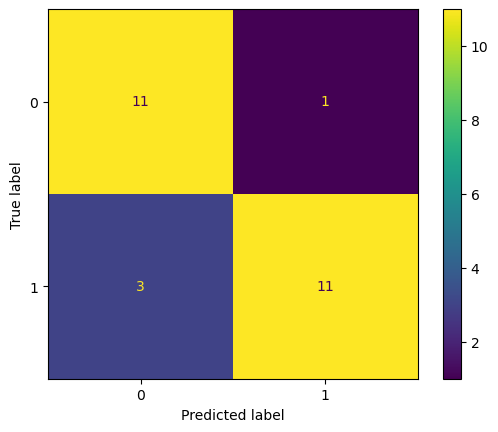

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = BEST_FITTED_MODEL.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictions)

ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

#### Classification report

In [11]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions, output_dict=True)
df_classification_report = DataFrame(report).transpose()
df_classification_report.sort_values(by=["f1-score"], ascending=False, inplace=True)
df_classification_report

,precision,recall,f1-score,support
0,0.785714,0.916667,0.846154,12.000000
1,0.916667,0.785714,0.846154,14.000000
accuracy,0.846154,0.846154,0.846154,0.846154
macro avg,0.851190,0.851190,0.846154,26.000000
weighted avg,0.856227,0.846154,0.846154,26.000000


#### SAVE MODEL
---

In [12]:
save_model(fitted_model=BEST_FITTED_MODEL, filepath="acme_best_model.jb")